In [ ]:
# try multi modal embedding
# TODO
# 5 types of embeddings
# early summation, early concat,  hierarchical att 1 and hierarchical att 2, cross attention, cross atten to con
# try multi modal embedding
# TODO
# 5 types of embeddings
# early summation, early concat,  hierarchical att 1 and hierarchical att 2, cross attention, cross atten to con


In [67]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
from torch import nn
from torchvision import transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.9.0+cu126
0.24.0+cu126
cuda


In [68]:
import os
import pandas as pd
from pathlib import Path
path_modality_rgb=Path("../data/ssvtp/images_rgb")
path_modality_tac=Path("../data/ssvtp/images_tac")
path_modality_text=Path("../data/ssvtp/text")
train_path="../data/ssvtp/train.csv"
base_path=Path("../data/ssvtp/")


df = pd.read_csv(train_path, on_bad_lines='skip')
print(len(df))
# pic_list_rgb=list(path_modality_rgb.glob("*.jpg"))
# pic_list_tac=list(path_modality_tac.glob("*.jpg"))
# pic_list_text=list(path_modality_text.glob("*.txt"))
# print(len(pic_list_rgb))
# print(len(pic_list_tac))
# print(len(pic_list_text))
df.iloc[0][0]


4538


'images_rgb/image_106_rgb.jpg'

In [69]:
import csv

bad_lines = []
with open("../data/ssvtp/train.csv", "r") as f:
    reader = csv.reader(f)
    header = next(reader)
    expected_cols = len(header)
    for i, row in enumerate(reader, start=2):  # start=2 to account for header
        if len(row) != expected_cols:
            bad_lines.append(i)

print(f"Number of bad lines: {len(bad_lines)}")
print("Bad line numbers:", bad_lines)

Number of bad lines: 3
Bad line numbers: [2474, 3171, 4225]


In [70]:
# create transform pipeline manually
IMG_SIZE=224 # as per transforemers requirement
transform_pipeline=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    ])
print(f"transform pipeline: {transform_pipeline}")

transform pipeline: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [71]:
from torch.utils.data import Dataset, DataLoader
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=transform_pipeline,img_dir=base_path):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path_rgb = self.img_dir / self.dataframe.iloc[idx, 0] # for RGB
        img_path_tac = self.img_dir / self.dataframe.iloc[idx, 1] # for RGB
        image_rgb = Image.open(img_path_rgb)
        image_tac = Image.open(img_path_tac)
        label = self.dataframe.iloc[idx, 2]

        if self.transform:
            image_rgb = self.transform(image_rgb)
            image_tac = self.transform(image_tac)

        return image_rgb, image_tac, label

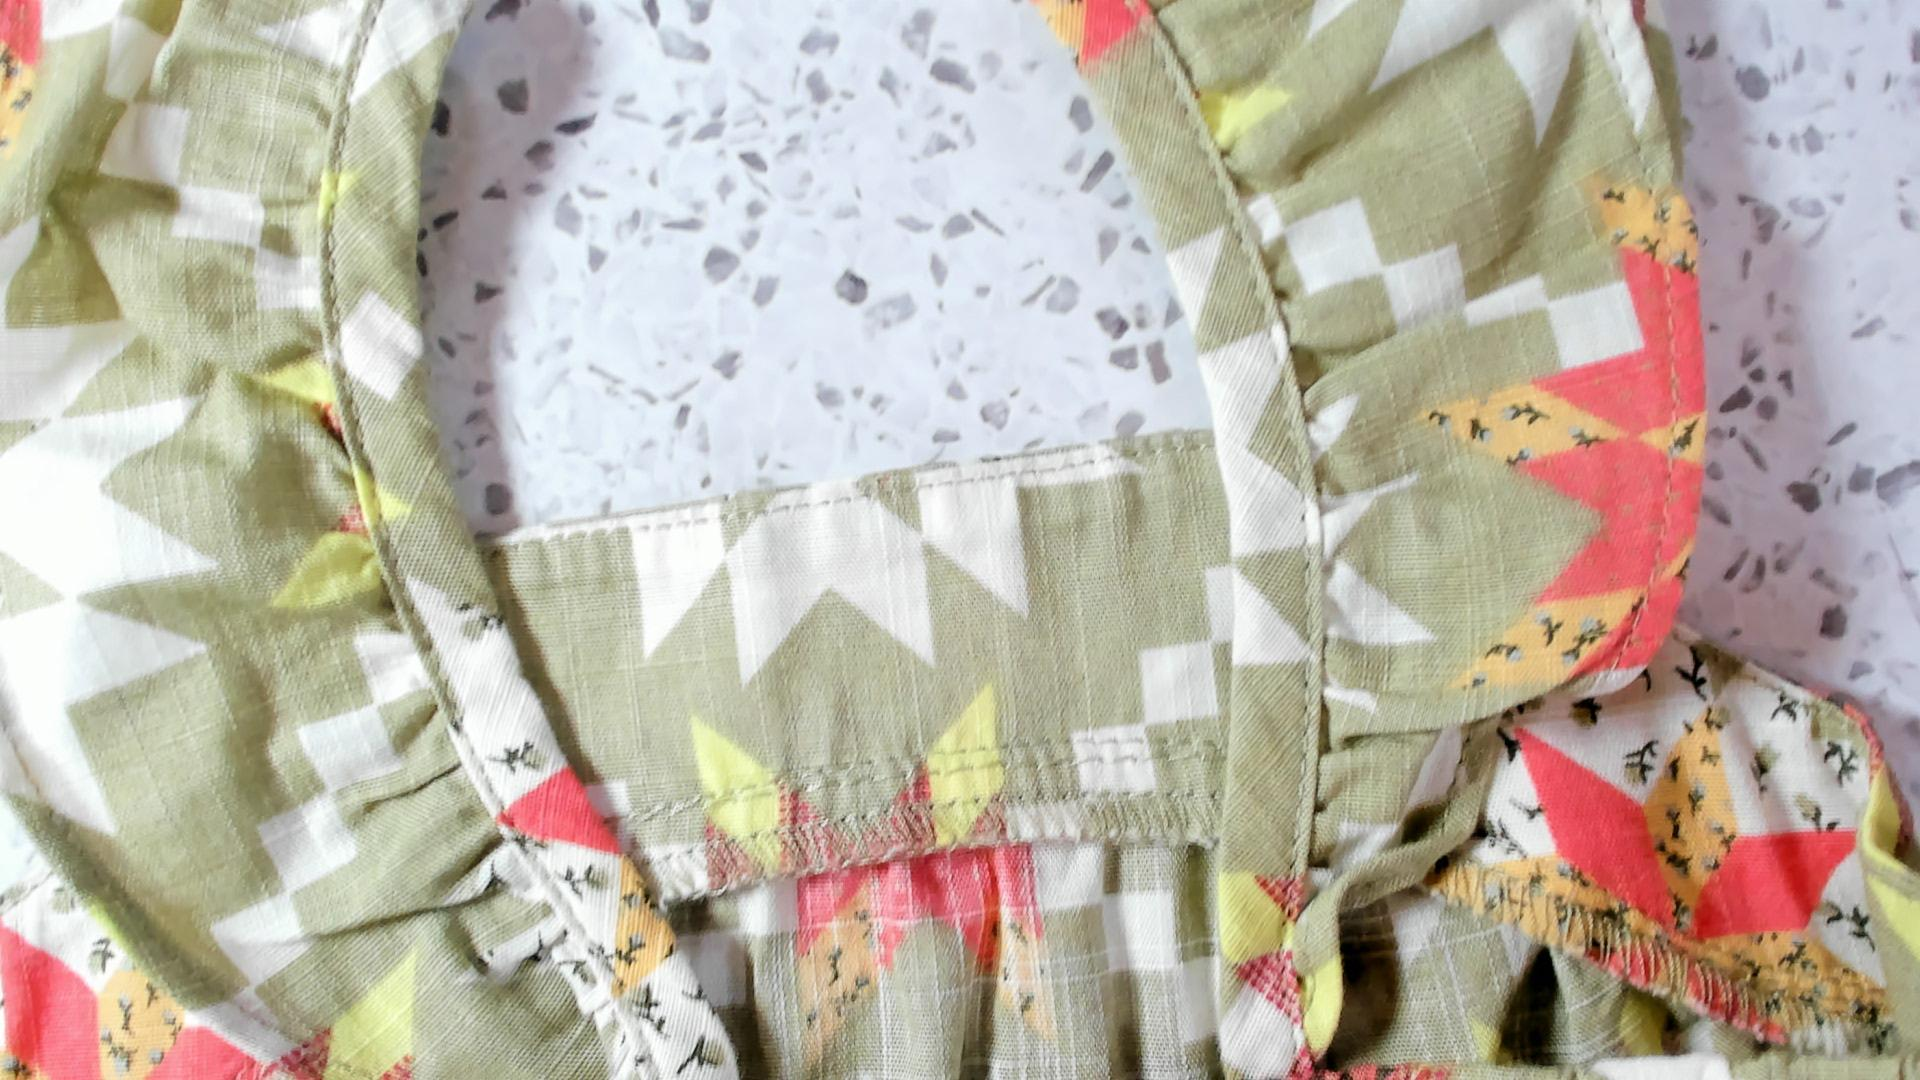

In [72]:
from  PIL import Image
img_path=base_path.joinpath(df.iloc[0][0])
img=Image.open(img_path)
img

In [73]:
dataset = CustomImageDataset(df, transform=transform_pipeline, img_dir=base_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [74]:
image=transform_pipeline(img)
image
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))

Image RGB batch shape: torch.Size([32, 3, 224, 224])
Image TAC batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: hard, smooth


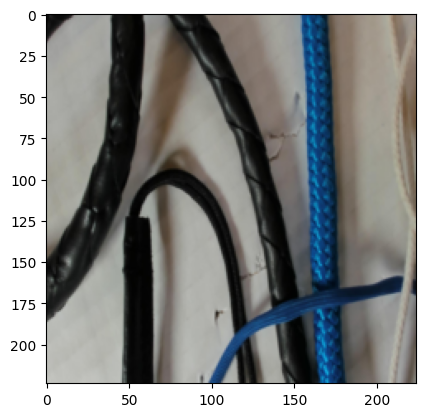

In [75]:
# get signgle image from dataloader
image_rgb, image_tac, label_batch=next(iter(dataloader))
print("Image RGB batch shape:", image_rgb.shape)
print("Image TAC batch shape:", image_tac.shape)
print("Label batch shape:", label_batch[0])
plt.imshow(image_rgb[0].permute(1,2,0))


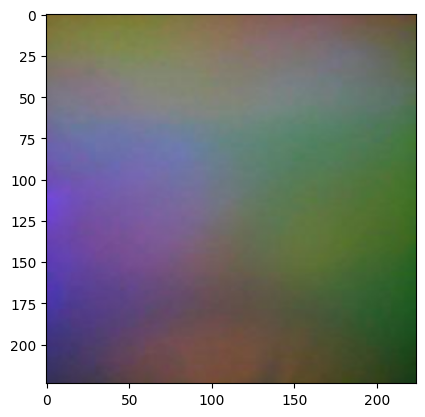

In [76]:
plt.imshow(image_tac[0].permute(1,2,0))

In [77]:
# patches for image
color_channel=3
patch_size=16
num_patches=(IMG_SIZE // patch_size) **2

In [78]:
embedding_layerInput_shape=(IMG_SIZE, IMG_SIZE, color_channel)
embedding_layerOutput_shape=(num_patches, patch_size*patch_size*color_channel)
print(f"Embedding layer input shape: {embedding_layerInput_shape}")
print(f"Embedding layer output shape: {embedding_layerOutput_shape}") # flatten embedding

Embedding layer input shape: (224, 224, 3)
Embedding layer output shape: (196, 768)


In [79]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_rgb.permute(1,2,0) -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_rgb[0].permute(1,2,0)[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{label_batch[0]} -> Patchified", fontsize=16)
plt.show()

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


In [80]:
# embedding patch
conv_layer=nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
conv_layer

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# start
image_out=conv_layer(image_tac[0].unsqueeze(0))
image_out.shape # shape-> batch, output feature map, feature map height, feature map width

torch.Size([1, 768, 14, 14])

torch.Size([1, 768, 196])

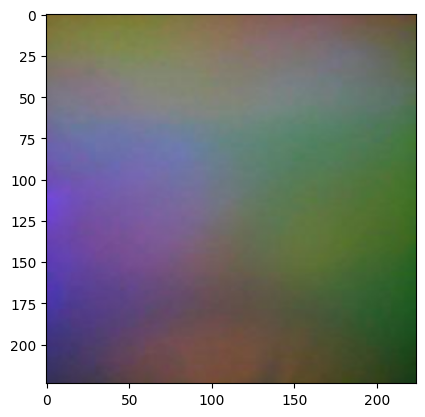

In [ ]:
# main points to make embeddings
# view single image, convert it into feature map, flatten the feature map
plt.imshow(image_tac[0].permute(1,2,0)) # show the tac image
image_out_conv_tac=conv_layer(image_tac[0].unsqueeze(0)) # image_out is the feature map
flattened= image_out_conv_tac.flatten(start_dim=2) # flatten the feature map
flattened.shape # shape-> batch, output feature map, flattened feature map

torch.Size([1, 196])


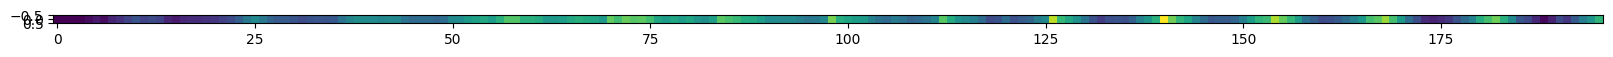

In [85]:
single_strip_flattened=flattened.permute(0,2,1)[:,:,0]
print(single_strip_flattened.shape)
plt.figure(figsize=(20,20))
plt.imshow(single_strip_flattened.detach().numpy())
plt.show()

In [ ]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size # height and width of image H*W
        self.patch_size = patch_size # P    (img_size//patch_size  = number of patches
        self.num_patches = (img_size // patch_size) ** 2  # not used

        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim, # D -> latent space dimension = Num of patches *channel size
                              kernel_size=patch_size,
                              stride=patch_size) 
        self.flatten = nn.Flatten(start_dim=2, end_dim=3) # flatten height and width dimensions
    # output is latens space dimension
    def forward(self, x):
        # question, how is the batch dimension handled here? -> x already has batch dimension
        # x shape: (batch_size, in_channels, img_size, img_size)
        image_size_check = x.shape[-1]
        assert image_size_check % self.patch_size == 0, f"Image size {image_size_check} is not divisible by patch size {self.patch_size}"
        x = self.proj(x)  # (batch_size, embed_dim, num_patches_height, num_patches_width)
        x = self.flatten(x)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x




In [101]:
patch_embeddings = PatchEmbeddings()
image_rgb[0].shape
patch_embeddings(image_rgb[0].unsqueeze(0)).shape

torch.Size([1, 196, 768])

In [92]:
from torchinfo import summary

In [93]:
summary(patch_embeddings, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
PatchEmbeddings                          [1, 196, 768]             --
├─Conv2d: 1-1                            [1, 768, 14, 14]          590,592
├─Flatten: 1-2                           [1, 768, 196]             --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [104]:
# creating modality embeddings
print(image_rgb.shape,image_tac.shape)
img_rgb_embd = patch_embeddings(image_rgb)
img_tac_embd = patch_embeddings(image_tac)
img_rgb_embd.shape, img_tac_embd.shape

# position embeddings
pos_embd= nn.Parameter(torch.ones(1, img_rgb_embd.shape[1], img_rgb_embd.shape[2]),requires_grad=True)
pos_embd.shape

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


torch.Size([1, 196, 768])

In [105]:
# Fusion of embeddings
# Early fusion by summation
fused_embd_sum= img_rgb_embd + img_tac_embd + pos_embd
fused_embd_sum.shape


torch.Size([32, 196, 768])

In [ ]:
class EarlyFuseEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(img_size, patch_size, in_channels, embed_dim)
        self.position_embeddings = nn.Parameter(torch.ones(1, (img_size // patch_size) ** 2, embed_dim), requires_grad=True)

    def forward(self, x1, x2):
        embd1 = self.patch_embeddings(x1)
        embd2 = self.patch_embeddings(x2)
        alpha, beta = 1.0, 1.0  # weights for each modality
        fused_embd = alpha * embd1 + beta * embd2 + self.position_embeddings
        return fused_embd
    

class EarlyConcatFuseEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(img_size, patch_size, in_channels, embed_dim)
        self.position_embeddings = nn.Parameter(torch.ones(1, (img_size // patch_size) ** 2, embed_dim * 2), requires_grad=True) # check if embd dim increases

    def forward(self, x1, x2):
        embd1 = self.patch_embeddings(x1)
        embd2 = self.patch_embeddings(x2)
        fused_embd = torch.cat((embd1, embd2), dim=-1) + self.position_embeddings
        return fused_embd
class HierarchicalAttentionFuseEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=8):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(img_size, patch_size, in_channels, embed_dim)
        self.position_embeddings = nn.Parameter(torch.ones(1, (img_size // patch_size) ** 2, embed_dim), requires_grad=True)
        self.attention = TransformerEncoderBlock()

    def forward(self, x1, x2):
        embd1 = self.patch_embeddings(x1)
        embd2 = self.patch_embeddings(x2)
        combined_embd =  + self.position_embeddings
        attn_output, _ = self.attention(combined_embd.transpose(0, 1), combined_embd.transpose(0, 1), combined_embd.transpose(0, 1))
        return attn_output.transpose(0, 1)

In [125]:
test_early_concat_fuse=EarlyConcatFuseEmbedding()
test_early_concat_fuse(image_rgb, image_tac).shape

torch.Size([32, 196, 1536])

In [120]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim:int=768, num_heads:int=12, attn_dropout:float=0.0):
        super().__init__()
        self.layernorm = nn.LayerNorm(normalized_shape=embed_dim) # what does it do here?
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=attn_dropout,batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_length, embed_dim)
        x = self.layernorm(x)
        # x = x.permute(1, 0, 2)  # (seq_length, batch_size, embed_dim)
        attn_output, _ = self.mha(query=x, key=x, value=x)
        # attn_output = attn_output.permute(1, 0, 2)  # (batch_size, seq_length, embed_dim)
        return attn_output

In [115]:
class MLPBlock(nn.Module):
    def __init__(self, embed_dim:int=768, mlp_dim:int=768*4, dropout:float=0.1):
        super().__init__()
        self.layernorm = nn.LayerNorm(normalized_shape=embed_dim)
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.sequential = nn.Sequential(
            self.fc1,
            self.gelu,
            self.dropout,
            self.fc2,
            self.dropout
        )

    def forward(self, x):
        x = self.layernorm(x)
        x = self.sequential(x)
        return x

In [121]:
# encoder
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim:int=768, num_heads:int=12, mlp_dim:int=768*4, attn_dropout:float=0.0, mlp_dropout:float=0.1):
        super().__init__()
        self.mha_block = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout)
        self.mlp_block = MLPBlock(embed_dim, mlp_dim, mlp_dropout)

    def forward(self, x):
        # Multi-head self-attention with residual connection
        attn_output = self.mha_block(x)
        x = x + attn_output
        
        # MLP block with residual connection
        mlp_output = self.mlp_block(x)
        x = x + mlp_output
        
        return x

In [122]:
# Transformer Encoder block
transformer_encodr_block=TransformerEncoderBlock()
# summary of transformer encoder block
print(img_rgb_embd[0].shape)
# transformer_encodr_block(img_rgb_embd[0].unsqueeze(0))
summary(transformer_encodr_block, input_size=(1, 196, 768))

torch.Size([196, 768])


Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderBlock                  [1, 196, 768]             --
├─MultiHeadSelfAttention: 1-1            [1, 196, 768]             --
│    └─LayerNorm: 2-1                    [1, 196, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 196, 768]             2,362,368
├─MLPBlock: 1-2                          [1, 196, 768]             --
│    └─LayerNorm: 2-3                    [1, 196, 768]             1,536
│    └─Sequential: 2-4                   [1, 196, 768]             --
│    │    └─Linear: 3-1                  [1, 196, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 196, 3072]            --
│    │    └─Dropout: 3-3                 [1, 196, 3072]            --
│    │    └─Linear: 3-4                  [1, 196, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 196, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr